# Analyse individual integration values of each image in each layer of each network

Multiple regression in each layer partitioning variance by three groups of models.

Predict beauty from integration in 23 taskonomy models. Do variance partitioning.

Problem: Multicolinearity of individual predictors, therefore, first examing correlation of integration between different models.

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

from scipy.stats import pearsonr, spearmanr

from itertools import combinations_with_replacement

In [2]:
DATASET_NAMES = ('places1', 'places2', 'oasis')
SCALE_NAMES = ('scale2','scale4','scale8','scale16','scale32')

DATA_PATH = './data_256x256'
BEHAVIOR_PATH = './behavior'
RESULTS_PATH = './results_taskonomy'

#VisualPrior.viable_feature_tasks
MODEL_NAMES = ('autoencoding','depth_euclidean','jigsaw','reshading',
               'edge_occlusion','keypoints2d','room_layout', #'colorization' currently not working
               'curvature','edge_texture','keypoints3d','segment_unsup2d',
               'class_object','egomotion','nonfixated_pose','segment_unsup25d',
               'class_scene','fixated_pose','normal','segment_semantic',
               'denoising','inpainting','point_matching','vanishing_point')

IMAGE_TRANSFORMS = ('untransformed')


In [3]:
NETS_SEMANTIC = ['class_object','class_scene','segment_semantic']

# from radek paper missing: colorization (not downloadable from taskonomy)
NETS_2D = ['autoencoding','denoising','edge_texture','inpainting','keypoints2d','segment_unsup2d']

# from radek paper missing: z-depth (missing from importing as well) and distance (but this is not a network after all)
NETS_3D = ['edge_occlusion','keypoints3d','segment_unsup25d','reshading','normal','curvature']

NETS_ALL = NETS_SEMANTIC + NETS_2D + NETS_3D

# load integration data

In [4]:
# load results
data_list = []


for model_name in MODEL_NAMES:
    for dataset_name in DATASET_NAMES:
        for scale_name in SCALE_NAMES:

            data = pd.read_csv(os.path.join(RESULTS_PATH, model_name, dataset_name, scale_name, 'correlations.csv'), header=None)
            data.insert(0, 'scale', scale_name)
            data.insert(0, 'dataset',dataset_name)
            data.insert(0, 'model', model_name)

            data_list.append(data)
            #selfsimilarity.to_csv(os.path.join(RESULTS_PATH, model_name, dataset_name, scale_name, 'selfsimilarity.csv'), index=False, header=False)           
            #l2norm.to_csv(os.path.join(RESULTS_PATH, model_name, dataset_name, scale_name, 'l2norm.csv'), index=False, header=False)

In [5]:
# convert correlation to integration
df = - pd.concat(data_list).set_index(['model','dataset','scale'])

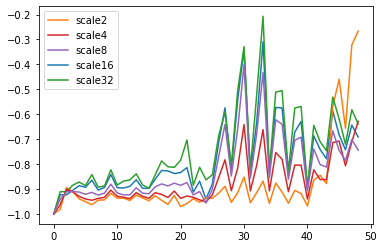

In [6]:
handles, labels = df.loc['autoencoding'].groupby('scale').mean().transpose().plot().get_legend_handles_labels()
order = [1, 3, 4, 0, 2]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

# function for calculating RDM

In [5]:
def calculate_rdm(data: pd.DataFrame, correlation_type : str = "pearson"):
    """Calculate RDM with pearson/spearman correlation for every combination of columns

    Parameters
    ----------
    data: pd.DataFrame
        Input with data to correlate in the columns

    correlation_type: str
        Which correlation to use. "pearson" (default) or "spearman".

        
    Returns
    -------
    pd.DataFrame
        representational dissimilarity matrix of inputs' columns
    
    """
    num_columns = data.shape[1]

    # create empty matrix to store RDM
    # index and column labels are in order of input columns
    rdm = pd.DataFrame(np.full((num_columns, num_columns), np.nan), columns=data.columns, index=data.columns)
    
    for col1, col2 in combinations_with_replacement(data.columns, 2):
        # there's one NaN in the autoencoding integration values, filter this here, don't know why that happens
        co11_col2 = data[[col1,col2]].dropna()
        
        # calculate correlation
        if correlation_type == "pearson":
            corr = pearsonr(co11_col2.values[:,0], co11_col2.values[:,1])[0]
        elif correlation_type == "spearman":
            corr = spearmanr(co11_col2.values[:,0], co11_col2.values[:,1])[0]

        # fill upper and lower triangular matrix
        rdm.loc[col1, col2] = corr
        rdm.loc[col2, col1] = corr
        rdm.loc[col1, col1] = 0.0

    return rdm

# do different nets integrate different things ?

correlate integration of images between individual networks and groups of networks.

plot representational dissimilarity matrix of network by network. correlating the integration to the image dataset. see if there's a clustering into the three groups.

## model RDM

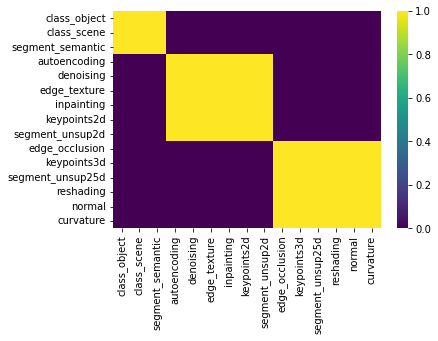

In [6]:
# create model RDM for semantiv-2D-3D nets integration
model_rdm = pd.DataFrame(
        np.full((len(NETS_ALL), len(NETS_ALL)), np.nan),
        columns=NETS_ALL, index=NETS_ALL)

for combi in combinations_with_replacement(NETS_ALL,2):
    if combi in combinations_with_replacement(NETS_SEMANTIC,2) or \
        combi in combinations_with_replacement(NETS_2D,2) or \
        combi in combinations_with_replacement(NETS_3D,2):
        model_rdm.loc[combi] = 1
        model_rdm.loc[tuple(reversed(combi))] = 1
    else:
        model_rdm.loc[combi] = 0
        model_rdm.loc[tuple(reversed(combi))] = 0

sns.heatmap(model_rdm, cmap='viridis')

## single layer

In [194]:
layer_id = 48

# fitler relevant data
layer_df = pd.DataFrame(df.loc[NETS_ALL,"places1", "scale8"][layer_id]).reset_index()
# needed for pivot into wide format
layer_df["img_id"] = layer_df.groupby("model").cumcount()

# pivot
layer_df = layer_df.pivot(columns="model", index="img_id", values=layer_id)

# reorder columns according to semantic-2D-3D nets
layer_df = layer_df[NETS_ALL]

rdm = calculate_rdm(layer_df, correlation_type="spearman")

In [195]:
pearsonr(rdm.values.flatten(), model_rdm.values.flatten())

(0.3301878324423006, 4.018289227621941e-07)

### visually inspect RDM

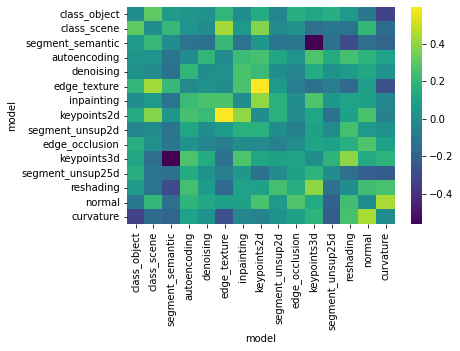

In [196]:
sns.heatmap(rdm, cmap='viridis')

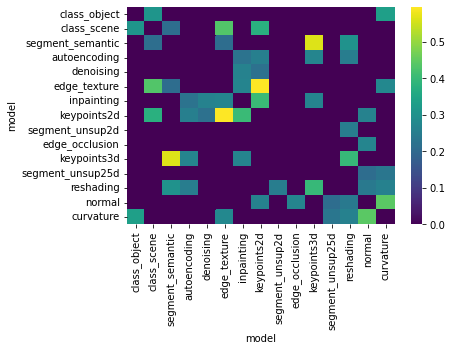

In [175]:
xdm = rdm.abs()[rdm.abs() > .2095].fillna(0)
sns.heatmap(xdm, cmap='viridis')

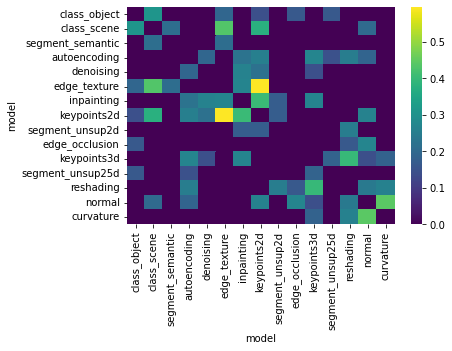

In [176]:
xdm = rdm[rdm > .142].fillna(0)
sns.heatmap(xdm, cmap='viridis')

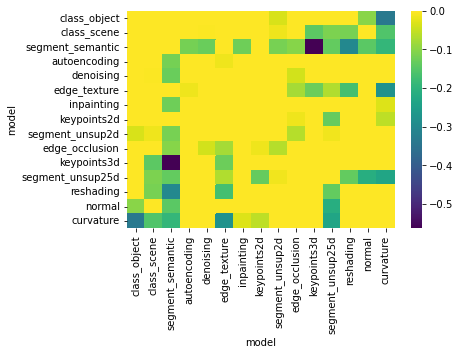

In [177]:
xdm = rdm[rdm < 0].fillna(0)
sns.heatmap(xdm, cmap='viridis')

## all layers

loop layers, scales, datasets

In [206]:
model_correlations = []
model_pvalues = []
# iterate layers
for layer_name, layer_series in df.loc[:,"places1", "scale8"].items():

    # put data back into DataFrame
    layer_df = pd.DataFrame(layer_series).reset_index()

    # needed for pivot into wide format
    layer_df["img_id"] = layer_df.groupby("model").cumcount()

    # pivot
    layer_df = layer_df.pivot(columns="model", index="img_id", values=layer_name)

    # reorder columns according to semantic-2D-3D nets
    layer_df = layer_df[NETS_ALL]

    rdm = calculate_rdm(layer_df, correlation_type="spearman")

    model_correlations.append(pearsonr(rdm.values.flatten(), model_rdm.values.flatten())[0])
    model_pvalues.append(pearsonr(rdm.values.flatten(), model_rdm.values.flatten())[1])

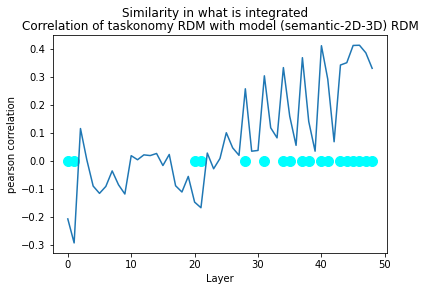

In [223]:
alpha = 0.05

sns.lineplot(data=model_correlations)
plt.suptitle("Similarity in what is integrated")
plt.title("Correlation of taskonomy RDM with model (semantic-2D-3D) RDM")
plt.xlabel("Layer")
plt.ylabel("pearson correlation")


for x, layer_pvalue in enumerate(model_pvalues):
    if layer_pvalue < alpha:
        plt.scatter(x, 0, color='cyan', s=100, marker='o')


# integration profiles across layers

for each network, perform layer x layer RSA of integration scores

test each rdm for sigificance by testing against a permutation distribution with shuffeled integration values

In [ ]:
with PdfPages("Integratio_layer_RSA.pdf") as pdf:
    for network_name in NETS_ALL:

        rdm = calculate_rdm(df.loc[network_name,'places1','scale8'])
        sns.heatmap(rdm)

        
        if network_name in NETS_SEMANTIC:
            network_class = "(semantic)"
        elif network_name in NETS_2D:
            network_class = "(2d)"
        elif network_name in NETS_3D:
            network_class = "(3d)"

        plt.title(network_name + network_class)
        
        
        pdf.savefig()
        plt.close()      
    

# do different scales of checkerboard patterns lead to integration of different things